In [24]:
from fastai import *
from fastai.vision import *
from PIL import *

# Demonstration of  speed and correctness of conversion of PIL Images to tensors

The result is that the proposed method "allPil2tensor" can handle both rgb and 16bit gray images correct

The existing method "Pil2tensor" can only handle jpg images/ 8 bit images

The proposed method is also slighty faster if we include the following conversion of float that takes place in open_image

In [25]:
# the existing method
def Pil2tensor(image:NPImage)->TensorImage:
    "handles numpy of rgb only - Convert PIL style `image` array to torch style image tensor."
    arr = ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))
    arr = arr.view(image.size[1], image.size[0], -1)
    return arr.permute(2,0,1)


In [26]:
#The proposed method
def allPil2tensor(image:NPImage)->TensorImage:
    #"handles all numpy format"
    arr = torch.from_numpy(np.asarray(image))
    arr = arr.view(arr.shape[1], arr.shape[0], -1)
    #arr = arr.view(image.size[1], image.size[0], -1)
    return arr.permute(2,0,1)

In [27]:
#The proposed method - fastest
def allPil2tensor2(image:NPImage)->TensorImage:
    arr = np.asarray(image)
    if arr.ndim==2 : arr = np.expand_dims(arr,2) 
    #transpose width, height to height,width
    arr = np.transpose(arr, (1,0,2))
    #move channels to the first position
    arr = np.transpose(arr, (2, 1, 0))
    return torch.from_numpy(arr)

# Test of speed

In [28]:
arr = np.random.randint(0, 2**8-1, (4, 7,3), dtype=np.uint8)  # or np.ones etc.
img = Image.fromarray(np.asarray(arr))

In [58]:
%timeit -r 20 Pil2tensor(img)

15.5 µs ± 625 ns per loop (mean ± std. dev. of 20 runs, 100000 loops each)


In [60]:
%timeit -r 20 allPil2tensor(img)

19.8 µs ± 644 ns per loop (mean ± std. dev. of 20 runs, 10000 loops each)


In [59]:
%timeit -r 20 allPil2tensor2(img)

12.2 µs ± 384 ns per loop (mean ± std. dev. of 20 runs, 100000 loops each)


In [32]:
np.asarray(img).shape

(4, 7, 3)

In [33]:
allPil2tensor(img).shape

torch.Size([3, 7, 4])

In [34]:
allPil2tensor2(img).shape

torch.Size([3, 4, 7])

# Test of handling af rgb image
Notice that the pixel values are preserved and the tensors size is correct for both conversion methods

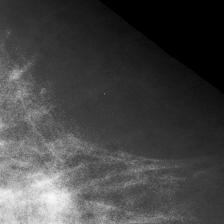

In [35]:
rbg16 = Image.open("16bit.jpg").convert("RGB")
rbg16

In [36]:
np.asarray(rbg16)[:,:,0]

array([[ 54,  54,  53,  52, ...,   0,   0,   0,   0],
       [ 54,  54,  53,  52, ...,   0,   0,   0,   0],
       [ 54,  54,  53,  52, ...,   0,   0,   0,   0],
       [ 54,  54,  53,  52, ...,   0,   0,   0,   0],
       ...,
       [195, 171, 173, 188, ...,  60,  60,  60,  60],
       [194, 180, 178, 185, ...,  60,  60,  60,  60],
       [190, 194, 189, 188, ...,  59,  59,  60,  60],
       [187, 204, 198, 192, ...,  59,  59,  59,  60]], dtype=uint8)

In [37]:
print(Pil2tensor(rbg16).size())
pil2tensor(rbg16).int()[0]

torch.Size([3, 224, 224])


tensor([[ 54,  54,  53,  ...,   0,   0,   0],
        [ 54,  54,  53,  ...,   0,   0,   0],
        [ 54,  54,  53,  ...,   0,   0,   0],
        ...,
        [194, 180, 178,  ...,  60,  60,  60],
        [190, 194, 189,  ...,  59,  60,  60],
        [187, 204, 198,  ...,  59,  59,  60]], dtype=torch.int32)

In [38]:
print(allPil2tensor(rbg16).size())
allPil2tensor(rbg16).int()[0]

torch.Size([3, 224, 224])


tensor([[ 54,  54,  53,  ...,   0,   0,   0],
        [ 54,  54,  53,  ...,   0,   0,   0],
        [ 54,  54,  53,  ...,   0,   0,   0],
        ...,
        [194, 180, 178,  ...,  60,  60,  60],
        [190, 194, 189,  ...,  59,  60,  60],
        [187, 204, 198,  ...,  59,  59,  60]], dtype=torch.int32)

In [39]:
print(allPil2tensor2(rbg16).size())
allPil2tensor2(rbg16).int()[0]

torch.Size([3, 224, 224])


tensor([[ 54,  54,  53,  ...,   0,   0,   0],
        [ 54,  54,  53,  ...,   0,   0,   0],
        [ 54,  54,  53,  ...,   0,   0,   0],
        ...,
        [194, 180, 178,  ...,  60,  60,  60],
        [190, 194, 189,  ...,  59,  60,  60],
        [187, 204, 198,  ...,  59,  59,  60]], dtype=torch.int32)

# Test of handling af 16bit grayscale png
Notice that Pil2tensor truncates the 16 bit values to 8 bit and that the tensor size i wrong

allPil2tensor preserve the pixel values and the tensor size is correct

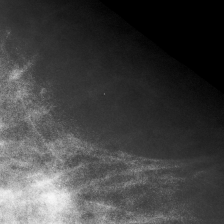

In [40]:
im16bit = Image.open("16bit.png").convert("I")
im16bit

In [41]:
np.asarray(im16bit)

array([[13052, 13048, 12476, 12707, ...,     0,     0,     0,     0],
       [13680, 13091, 13019, 13238, ...,     0,     0,     0,     0],
       [13085, 12747, 13274, 13004, ...,     0,     0,     0,     0],
       [12396, 12964, 12657, 12899, ...,     0,     0,     0,     0],
       ...,
       [51303, 45715, 44217, 48575, ..., 14463, 15409, 14098, 14638],
       [47507, 44621, 46204, 47109, ..., 14546, 15133, 14347, 14767],
       [50976, 48555, 48834, 49901, ..., 13900, 14542, 15126, 14977],
       [49620, 51061, 50370, 50167, ..., 14751, 14602, 15097, 14475]], dtype=int32)

In [42]:
print(Pil2tensor(im16bit).size())
Pil2tensor(im16bit).int()

torch.Size([4, 224, 224])


tensor([[[252, 248, 188,  ...,   0,   0,   0],
         [112,  35, 219,  ...,   0,   0,   0],
         [ 29, 203, 218,  ...,   0,   0,   0],
         ...,
         [147,  77, 124,  ...,  29,  11, 175],
         [ 32, 171, 194,  ..., 206,  22, 129],
         [212, 117, 194,  ...,  10, 249, 139]],

        [[ 50,  50,  48,  ...,   0,   0,   0],
         [ 53,  51,  50,  ...,   0,   0,   0],
         [ 51,  49,  51,  ...,   0,   0,   0],
         ...,
         [185, 174, 180,  ...,  59,  56,  57],
         [199, 189, 190,  ...,  56,  59,  58],
         [193, 199, 196,  ...,  57,  58,  56]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  

In [43]:
print(allPil2tensor(im16bit).size())
allPil2tensor(im16bit).int()

torch.Size([1, 224, 224])


tensor([[[13052, 13048, 12476,  ...,     0,     0,     0],
         [13680, 13091, 13019,  ...,     0,     0,     0],
         [13085, 12747, 13274,  ...,     0,     0,     0],
         ...,
         [47507, 44621, 46204,  ..., 15133, 14347, 14767],
         [50976, 48555, 48834,  ..., 14542, 15126, 14977],
         [49620, 51061, 50370,  ..., 14602, 15097, 14475]]], dtype=torch.int32)

In [44]:
print(allPil2tensor2(im16bit).size())
allPil2tensor2(im16bit).int()

torch.Size([1, 224, 224])


tensor([[[13052, 13048, 12476,  ...,     0,     0,     0],
         [13680, 13091, 13019,  ...,     0,     0,     0],
         [13085, 12747, 13274,  ...,     0,     0,     0],
         ...,
         [47507, 44621, 46204,  ..., 15133, 14347, 14767],
         [50976, 48555, 48834,  ..., 14542, 15126, 14977],
         [49620, 51061, 50370,  ..., 14602, 15097, 14475]]], dtype=torch.int32)